# Extremely Convoluted Plotting Code - Reading Directly Off Output Files

_Big regret needing to work out how to do this, when I should've just put output stats directly into its own file... ah well_

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
def parse_file_parallels(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    if "OpenMP" in filepath:
        proc_count = int(lines[3].split()[4])
        lattice_size = int(lines[2].split()[4].split('x')[0])
        threads = proc_count  # Can be extracted if OpenMP line exists
        proc_count = None
    else:
        proc_count = int(lines[2][20])
        lattice_size = int(lines[3].split()[4].split('x')[0])
        threads = None
    run_time = float(lines[6].split()[4])

    df = pd.read_csv(
        filepath,
        sep=r'\s+',
        comment="#",
        names=["MC step", "Ratio", "Energy", "Order"]
    )

    df["Proc Count"] = proc_count
    df["Lattice Size"] = lattice_size
    df["Threads"] = threads
    df["Run Time (s)"] = run_time
    df["Category"] = os.path.basename(os.path.dirname(filepath))
    
    return df


In [4]:
def parse_file_one_procs(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    
    proc_count = 1
    lattice_size = int(lines[2].split()[4].split('x')[0])
    threads = 1
    run_time = float(lines[5].split()[4])

    df = pd.read_csv(
        filepath,
        sep=r'\s+',
        comment="#",
        names=["MC step", "Ratio", "Energy", "Order"]
    )

    df["Proc Count"] = proc_count
    df["Lattice Size"] = lattice_size
    df["Threads"] = threads
    df["Run Time (s)"] = run_time
    df["Category"] = os.path.basename(os.path.dirname(filepath))
    
    return df

In [5]:
data_folders = {"serial":"data/Serial",
                "MPI":"data/MPI",
                "Cython":"data/Cython_cdef",
                "Cython_OpenMP":"data/Cython_OpenMP",
                "MPI_Cython":"data/MPI_Cython",
                "numba":"data/numba_JIT",
                "Vectorised":"data/Vectorised"}

<bound method NDFrame.head of         MC step   Ratio     Energy   Order Proc Count  Lattice Size Threads  \
0             0  0.5000  -624.6557  0.3046          1            25    None   
1             1  0.3120  -757.9013  0.3188          1            25    None   
2             2  0.3392  -872.7701  0.3216          1            25    None   
3             3  0.3104  -965.9033  0.3313          1            25    None   
4             4  0.3152 -1048.5562  0.3404          1            25    None   
...         ...     ...        ...     ...        ...           ...     ...   
384782      246  0.4752 -2355.9645  0.9204          1            25       1   
384783      247  0.4688 -2360.1326  0.9171          1            25       1   
384784      248  0.5056 -2370.0091  0.9239          1            25       1   
384785      249  0.4608 -2366.6379  0.9211          1            25       1   
384786      250  0.4640 -2362.5274  0.9199          1            25       1   

        Run Time (s) 

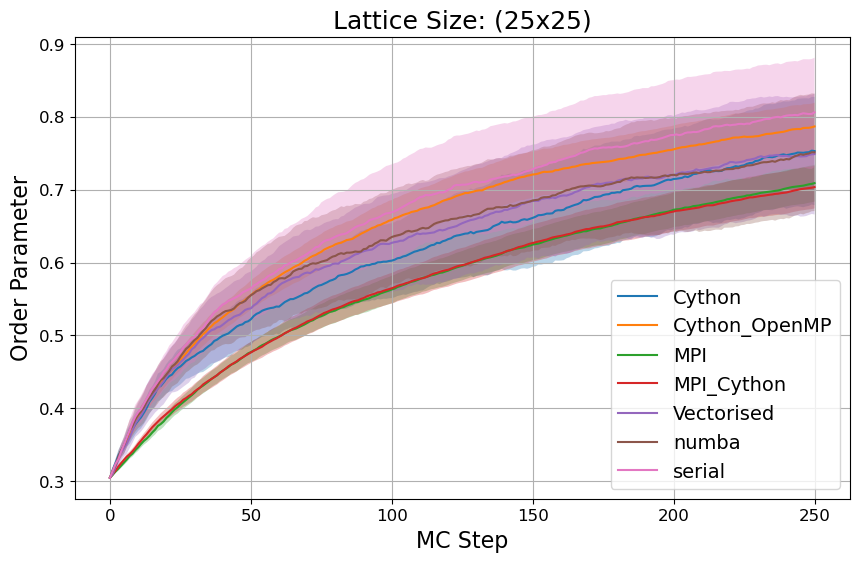

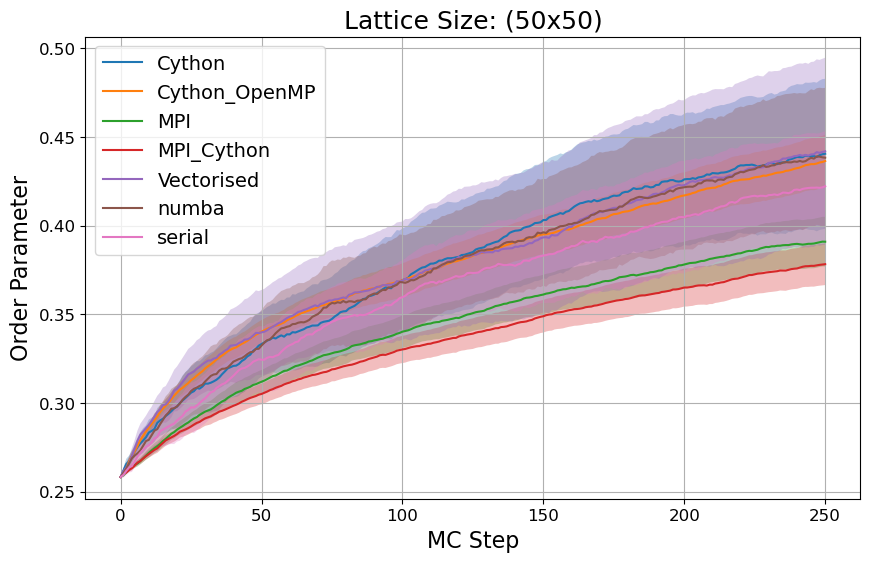

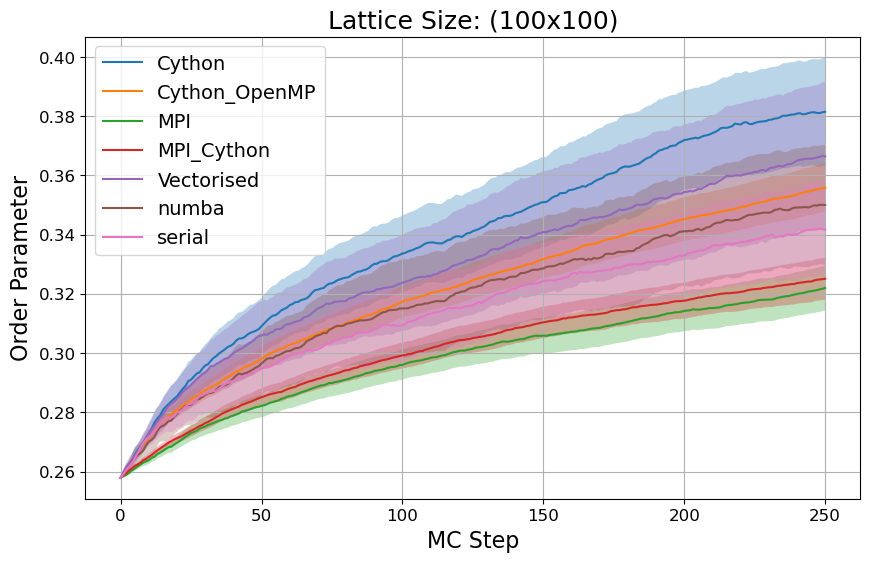

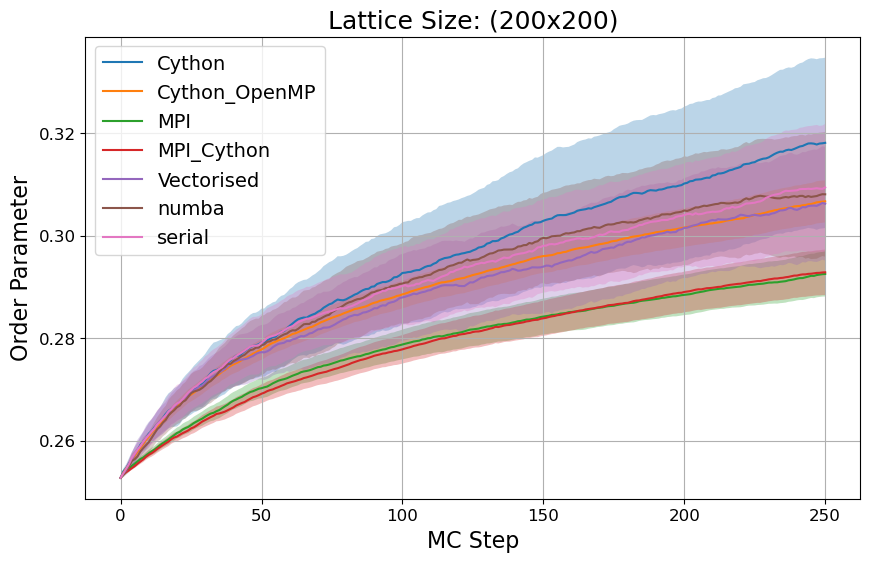

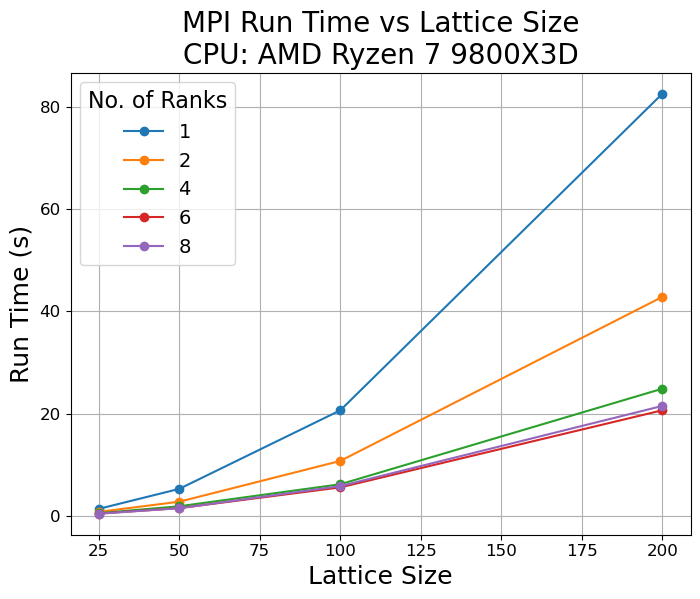

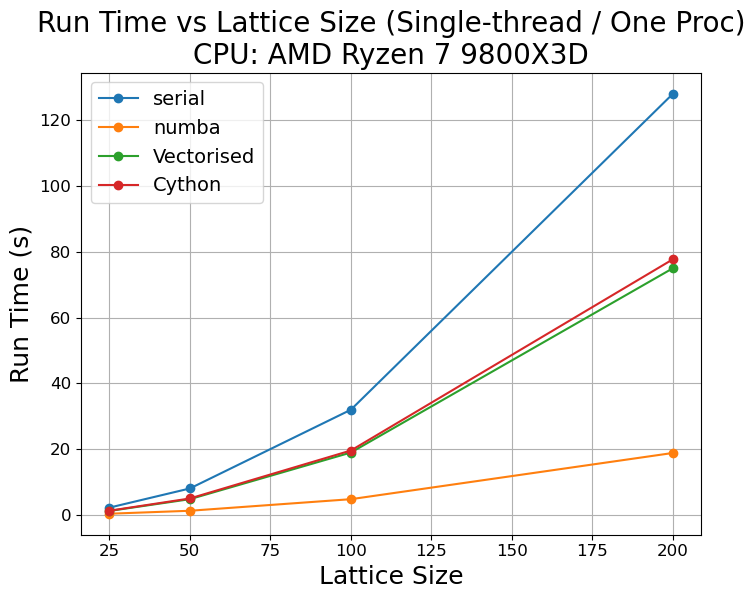

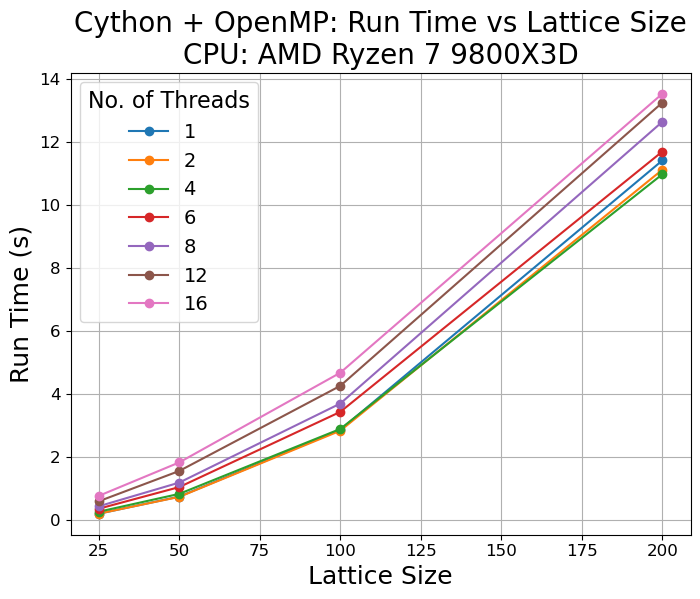

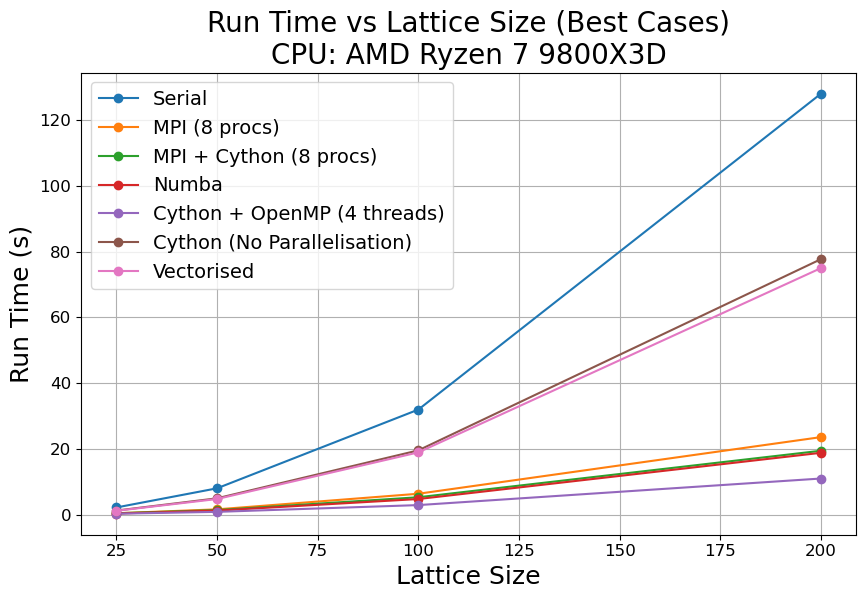

In [6]:
## Aggregate all non-serial files
all_dfs = []
for key, folder in data_folders.items():
    if key == "serial" or key == "numba" or key == "Vectorised" or key == "Cython":
        continue  # skip serial for now
    for fname in sorted(os.listdir(folder)):
        filepath = os.path.join(folder, fname)
        df = parse_file_parallels(filepath)
        df["Dict Key"] = key
        all_dfs.append(df)

## Aggregate all serial files (i.e files that ran on 1 proc or thread)
for key, folder in data_folders.items():
    if key == "MPI" or key == "Cython_OpenMP" or key == "MPI_Cython":
        continue  # skip parallle
    for fname in sorted(os.listdir(folder)):
        filepath = os.path.join(folder, fname)
        df = parse_file_one_procs(filepath)
        df["Dict Key"] = key
        all_dfs.append(df)

data = pd.concat(all_dfs, ignore_index=True)
display(data.head)

# Plots for each lattice size
for lattice in sorted(data["Lattice Size"].unique()):
    plt.figure(figsize=(10,6))
    for key in sorted(data["Dict Key"].unique()):
        df_plot = data[(data["Dict Key"] == key) & (data["Lattice Size"] == lattice)]
        if df_plot.empty:
            continue
        # average and sem Order over multiple runs per MC step
        df_grouped = df_plot.groupby("MC step")["Order"]
        mean_values = df_grouped.mean()
        sem_values = df_grouped.sem() 
        
        plt.plot(mean_values.index, mean_values.values, label=key)
        
        plt.fill_between(
            mean_values.index, 
            mean_values - 2*sem_values, 
            mean_values + 2*sem_values, 
            alpha=0.3
        )
    
    plt.xlabel("MC Step", fontsize = 16)
    plt.ylabel("Order Parameter", fontsize = 16)
    plt.title(f"Lattice Size: ({lattice}x{lattice})", fontsize = 18)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(True)
    plt.savefig(f"plots/Lattice Size: {lattice}x{lattice}.pdf")
    plt.show()

# MPI: Run Time vs Lattice Size
mpi_keys = ["MPI", "MPI_Cython"]
mpi_data = data[data["Dict Key"].isin(mpi_keys)]
mpi_times = mpi_data.groupby(["Lattice Size", "Proc Count"])["Run Time (s)"].mean().reset_index()

plt.figure(figsize=(8,6))
for nproc in sorted(mpi_times["Proc Count"].unique()):
    df_plot = mpi_times[mpi_times["Proc Count"] == nproc]
    plt.plot(df_plot["Lattice Size"], df_plot["Run Time (s)"], marker='o', label=f"{nproc}")

plt.xlabel("Lattice Size", fontsize = 18)
plt.ylabel("Run Time (s)", fontsize = 18)
plt.title("MPI Run Time vs Lattice Size\nCPU: AMD Ryzen 7 9800X3D", fontsize = 20)
plt.legend(title = "No. of Ranks",title_fontsize = 16, fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.savefig(f"plots/MPI_Timings.pdf")
plt.show()

# Run Time vs Lattice Size for single-thread implementations
single_thread_keys = ["serial", "numba", "Vectorised", "Cython"]
single_data = data[data["Dict Key"].isin(single_thread_keys)]
single_times = single_data.groupby(["Lattice Size","Dict Key"])["Run Time (s)"].mean().reset_index()

plt.figure(figsize=(8,6))
for key in single_thread_keys:
    df_plot = single_times[single_times["Dict Key"] == key]
    plt.plot(df_plot["Lattice Size"], df_plot["Run Time (s)"], marker='o', label=key)

plt.xlabel("Lattice Size", fontsize = 18)
plt.ylabel("Run Time (s)", fontsize = 18)
plt.title("Run Time vs Lattice Size (Single-thread / One Proc)\nCPU: AMD Ryzen 7 9800X3D", fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.savefig(f"plots/Serial_Timings.pdf")
plt.show()

# Cython + OpenMP: Run Time vs Lattice Size
omp_data = data[data["Dict Key"] == "Cython_OpenMP"]
omp_times = omp_data.groupby(["Lattice Size", "Threads"])["Run Time (s)"].mean().reset_index()

plt.figure(figsize=(8,6))
for th in sorted(omp_times["Threads"].unique()):
    df_plot = omp_times[omp_times["Threads"] == th]
    plt.plot(df_plot["Lattice Size"], df_plot["Run Time (s)"], marker='o', label=f"{th}")

plt.xlabel("Lattice Size", fontsize = 18)
plt.ylabel("Run Time (s)", fontsize = 18)
plt.title("Cython + OpenMP: Run Time vs Lattice Size\nCPU: AMD Ryzen 7 9800X3D", fontsize = 20)
plt.legend(title = "No. of Threads",title_fontsize = 16 ,fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.savefig(f"plots/OpenMP_Timings.pdf")
plt.show()

# Everything plot: Run Time vs Lattice Size
plt.figure(figsize=(10,6))

# ---------------------- Serial ----------------------
serial_data = data[data["Dict Key"] == "serial"]
grouped = serial_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="Serial")

# ---------------------- MPI (8 procs) ----------------------
mpi_data = data[(data["Dict Key"] == "MPI") & (data["Proc Count"] == 8)]
grouped = mpi_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="MPI (8 procs)")

# -------------------------MPI + Cython (8 procs) ----------------------
mpi_cython_data = data[(data["Dict Key"] == "MPI_Cython") & (data["Proc Count"] == 8)]
grouped = mpi_cython_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="MPI + Cython (8 procs)")

# ---------------------- Numba ----------------------
numba_data = data[data["Dict Key"] == "numba"]
grouped = numba_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="Numba")

# ---------------------- OpenMP (4 threads) ----------------------
omp_data = data[(data["Dict Key"] == "Cython_OpenMP") & (data["Threads"] == 4)]
grouped = omp_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="Cython + OpenMP (4 threads)")

# ---------------------- Cython ----------------------
cython_data = data[data["Dict Key"] == "Cython"]
grouped = cython_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="Cython (No Parallelisation)")

# ---------------------- Vectorised ----------------------
vectorised_data = data[data["Dict Key"] == "Vectorised"]
grouped = vectorised_data.groupby("Lattice Size")["Run Time (s)"].mean().reset_index()
plt.plot(grouped["Lattice Size"], grouped["Run Time (s)"], marker='o', label="Vectorised")

# ---------------------- Plot formatting ----------------------
plt.xlabel("Lattice Size", fontsize = 18)
plt.ylabel("Run Time (s)", fontsize = 18)
plt.title("Run Time vs Lattice Size (Best Cases)\nCPU: AMD Ryzen 7 9800X3D", fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.savefig(f"plots/Best_Case_Timings.pdf")
plt.show()



In [ ]:
# Make column to uniquely store every config inc thread count and proc count
data["Config"] = data["Dict Key"]

# Add thread/proc info for parallel implementations
data.loc[data["Dict Key"] == "Cython_OpenMP", "Config"] = data["Dict Key"] + " (" + data["Threads"].astype(str) + " threads)"
data.loc[data["Dict Key"].isin(["MPI", "MPI_Cython"]), "Config"] = data["Dict Key"] + " (" + data["Proc Count"].astype(str) + " procs)"

mean_times = data.groupby(["Lattice Size", "Config"]).agg({"Run Time (s)": "mean"}).reset_index()

# Get serial baseline
serial_times = mean_times[mean_times["Config"] == "serial"][["Lattice Size", "Run Time (s)"]]
serial_times = serial_times.rename(columns={"Run Time (s)": "Serial Time"})

merged = mean_times.merge(serial_times, on="Lattice Size")

merged["Pct Increase (%)"] = (merged["Run Time (s)"] - merged["Serial Time"]) / merged["Serial Time"] * 100

# make pivot table for all categories (SCIF30006 coming in clutch)
table = merged.pivot_table(index="Lattice Size", columns="Config", values="Pct Increase (%)")

display(table)



Config,Cython,Cython_OpenMP (1 threads),Cython_OpenMP (12 threads),Cython_OpenMP (16 threads),Cython_OpenMP (2 threads),Cython_OpenMP (4 threads),Cython_OpenMP (6 threads),Cython_OpenMP (8 threads),MPI (1 procs),MPI (2 procs),MPI (4 procs),MPI (8 procs),MPI_Cython (1 procs),MPI_Cython (2 procs),MPI_Cython (4 procs),MPI_Cython (6 procs),MPI_Cython (8 procs),Vectorised,numba,serial
Lattice Size,,,,,,,,,,,,,,,,,,,,
25,-43.687715,-91.194926,-72.865737,-64.928916,-91.114389,-88.257759,-83.835217,-80.246354,-30.183070,-60.642124,-75.497232,-81.911228,-45.830138,-69.673739,-78.425419,-80.392861,-81.986788,-46.916298,-85.900307,0.0
50,-38.117759,-90.830518,-80.634894,-77.233505,-90.926308,-89.734675,-87.035585,-85.253045,-26.234069,-61.954101,-75.136378,-80.169512,-42.250901,-69.425459,-78.581277,-81.416533,-83.059496,-40.783400,-84.916578,0.0
100,-38.849543,-91.065368,-86.700359,-85.396873,-91.157802,-90.983379,-89.285003,-88.458145,-27.305937,-62.452272,-78.832576,-80.177280,-43.540645,-70.422310,-82.611273,-82.643746,-83.521464,-40.767132,-85.199816,0.0
200,-39.314762,-91.095383,-89.661629,-89.441416,-91.325452,-91.438139,-90.874531,-90.136590,-27.156570,-62.673801,-78.655507,-81.599431,-43.849091,-70.438100,-82.518782,-83.888059,-84.843753,-41.439974,-85.327892,0.0
